# RSSI Wifi and Bluetooh Data Fusion Random Forest Regression Model

### Loading the necessary libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, recall_score, hamming_loss
import matplotlib.pyplot as plt


### Loading the Dataset

In [4]:
# Load the datasets
ibeacon_data = pd.read_csv(r'C:\Users\Hp\OneDrive\Indoor Localization using RSSI Dataset\archive (1)\iBeacon_RSSI_Labeled.csv')
training_data = pd.read_csv(r'C:\Users\Hp\OneDrive\Indoor Localization using RSSI Dataset\archive (1)\TrainingData.csv')

# Convert dates to datetime format for future merging based on time if necessary
ibeacon_data['date'] = pd.to_datetime(ibeacon_data['date'], errors='coerce')

### Extracting the features

In [5]:
# Select relevant columns from the training data
training_data_reduced = training_data[['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION']]

# Combine ibeacon RSSI features with training data for modeling
ibeacon_features = ibeacon_data.iloc[:, 2:]  # Columns starting from 'b3001' onwards
merged_data = pd.concat([training_data_reduced.reset_index(drop=True), ibeacon_features.reset_index(drop=True)], axis=1)

# Handle missing values in ibeacon RSSI data by imputing with mean
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### Splitting the Dataset into Train and Test Data

In [8]:
# Define features and target variables
X = merged_data.drop(columns=['LONGITUDE', 'LATITUDE'])
y = merged_data[['LONGITUDE', 'LATITUDE']]

# Preprocess features
X_preprocessed = preprocessing_pipeline.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


### Training the Data for Random Forest Regression Model

In [9]:
# Use Random Forest Regressor for indoor localization
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


### Calculating the Evaluation Metrices

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, recall_score, hamming_loss

# Ensure you are working with discrete values for classification
y_test_classified = np.array(y_test.round())  # Convert to NumPy array if it's a DataFrame
y_pred_classified = np.array(y_pred.round())  # Convert to NumPy array if it's a DataFrame

# Calculate MSE and MAE for multi-output regression
mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
mae = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')

# For classification metrics, calculate them per output (each column) and then average
f1_scores = []
recall_scores = []
hamming_losses = []

for i in range(y_test_classified.shape[1]):
    f1_scores.append(f1_score(y_test_classified[:, i], y_pred_classified[:, i], average='macro', zero_division=1))
    recall_scores.append(recall_score(y_test_classified[:, i], y_pred_classified[:, i], average='macro', zero_division=1))
    hamming_losses.append(hamming_loss(y_test_classified[:, i], y_pred_classified[:, i]))

# Average the scores for all outputs
f1 = np.mean(f1_scores)
recall = np.mean(recall_scores)
hamming = np.mean(hamming_losses)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("F1 Score:", f1)
print("Recall:", recall)
print("Hamming Loss:", hamming)
print("Accuracy:",100-mse)


Mean Squared Error (MSE): 1.5851131414457331
Mean Absolute Error (MAE): 0.28055301701293417
F1 Score: 0.8803110790949626
Recall: 0.9325897366351492
Hamming Loss: 0.0687061183550652
Accuracy: 98.41488685855427


### User Plot: Latitude vs Longitude

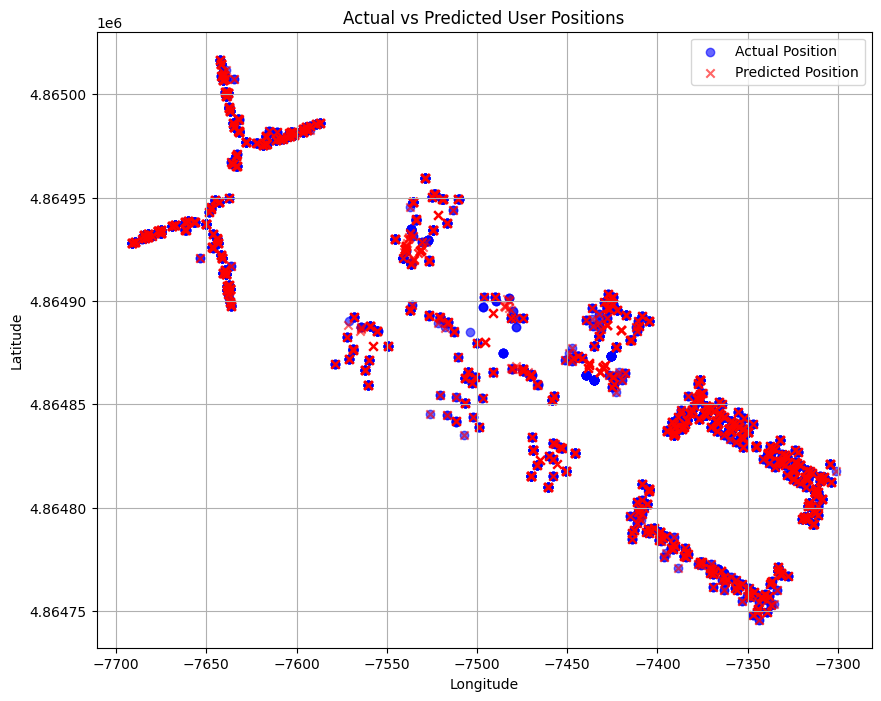

In [17]:
# Scatter plot for actual vs predicted user positions
plt.figure(figsize=(10, 8))
plt.scatter(y_test['LONGITUDE'], y_test['LATITUDE'], color='blue', label='Actual Position', alpha=0.6)
plt.scatter(y_pred[:, 0], y_pred[:, 1], color='red', marker='x', label='Predicted Position', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted User Positions')
plt.legend()
plt.grid(True)
plt.show()